In [41]:
import sys
sys.path.append('/disk/bifrost/yuanze/software/GalfitS/src')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import images as IM
from astropy.coordinates import SkyCoord
import pickle
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import simple_norm
from astropy.table import Table, Column
import matplotlib.pyplot as plt
import numpy as np
import time
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM,z_at_value
from astropy.io import fits, ascii
from astropy.wcs import WCS

from spectral_cube import SpectralCube

In [58]:
-2.5*np.log10(header["PHOTFLAM"])-21.1

28.19707300926475

In [123]:
sourcename="MD17"
field="Q1549"
KBSSpath="/disk/bifrost/yuanze/KBSS"


qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==sourcename]


conver={"ch2":0.1382,"ch4":0.2026}
#dataname="q1549_irac_"+subtype+"_mosaic.fits"
filter="f606w"
instrument="acs"
dataname="Q1549_F606W_075_drc_sci.fits"
datatype="hst"
ra = sentry["RA"].value[0]
dec = sentry["Dec"].value[0]
cutr = float (3)
sc=SkyCoord(ra=ra,dec=dec,unit="deg")

datapath=KBSSpath+"/"+field+"/"+datatype+"/"+dataname

fname = datapath
hdu = fits.open(datapath)
header = hdu[0].header


spitzerlambda=np.array([3.6,4.5,5.8,8.0])*u.micron
A=(0.6*np.pi/180/3600)**2

In [118]:
C=8.461595E-06
#C = 8.461595E-06 Jy/pixel/(MJy/sr). Therefore the equation becomes
JytoFnu=1e-23*(u.erg/u.s/u.cm**2/u.Hz)/u.Jy
Lambda=spitzerlambda.to(u.cm)
FJytoFlambda=ccgs/Lambda**2*JytoFnu*C
print(1/FJytoFlambda.to(u.erg/u.cm**2/u.AA/u.s/u.Jy))
#1/(erg*Sr/s/cm2/A/MJy/pixel)
#conversion from MJy/Sr to Flambda/pixel
FJytoFnu=C*JytoFnu
print(FJytoFnu)

NameError: name 'ccgs' is not defined

In [71]:
def write_fits(image, ra, dec, outputname, header = None,cutimg=None, addpixsc = False):
        '''
        Write the cut image to a FITS file.
        In order [cut_image, cut_mask_image, cut_sigma_image]
        '''
        if header is None:
            header=image.data.header
        hdu_temp = fits.PrimaryHDU(np.float32(image), header=header)
        hdu_temp.header['CRVAL1'] = ra
        hdu_temp.header['CRVAL2'] = dec
        hdu_temp.header['EXPTIME'] = 1
        hdu_temp.header['CRPIX1'] = cutimg.sources_skycord_cut[0]
        hdu_temp.header['CRPIX2'] = cutimg.sources_skycord_cut[1]
        if addpixsc:
            hdu_temp.header['CDELT1'] = cutimg.pixel_scales[0].value/3600
            hdu_temp.header['CDELT2'] = cutimg.pixel_scales[1].value/3600
#        hdu_temp2 = fits.ImageHDU(np.float32(self.cut_mask_image))
#        hdu_temp3 = fits.ImageHDU(np.float32(self.cut_sigma_image))
        hdul = fits.HDUList([hdu_temp])
        hdul.writeto(outputname, overwrite=True)
        return

# Image cut

In [128]:
cutr=2.1
#covimgpath= obspath+"/"+datatype+"/"+"q1549_irac_"+subtype+"_cov.fits"
img = IM.image(fname)
hdu = fits.open(fname)
imcut, cp = img.img_cut(ra,dec,cutr)
sky_mean, sky_median, sky_std = sigma_clipped_stats(imcut, sigma=3, maxiters=5)
header = img.data.header
#if False:
#    print("reading covariance image at",covimgpath)
#    covimg=fits.open(covimgpath)[0].data
#    img.cut_sigma_image = np.sqrt(covimg[cp[2]:cp[3],cp[0]:cp[1]])*conver[subtype]
    
#else:
sigimg = img.cal_sigma_image(img.data.header["EXPTIME"], gain = 1.)
img.cut_sigma_image = sigimg[cp[2]:cp[3],cp[0]:cp[1]]
#img.cut_mask_image = np.zeros_like(img.cut_sigma_image)
img.cut_mask_image = img.generate_cutmask(0.5,nsigma=2,sky_level=sky_mean,deblend=False,addgrow=3)
#outname = obspath+"/"+datatype+'/'+'q1549_'+datatype+'_'+subtype+'_cutimg.fits'
outname = KBSSpath+"/"+field+'/'+sourcename+'/'+datatype+'/'+sourcename+'_'+instrument+'_'+filter
print("writing cut image to",outname)
#writing sigma image
write_fits(sigimg[cp[2]:cp[3],cp[0]:cp[1]],ra,dec,outname+'_cutsigma.fits',cutimg=img,header=header)
#writing mask image
write_fits(img.cut_mask_image,ra,dec,outname+'_cutmask.fits',cutimg=img,header=header)
#writing cut image
write_fits(img.cut_image,ra,dec,outname+'_cutimg.fits',cutimg=img,header=header)
#img.write_imcut(ra,dec,outname+'_cutimg.fits',header=header)



writing cut image to /disk/bifrost/yuanze/KBSS/Q1549/MD17/hst/MD17_acs_f606w


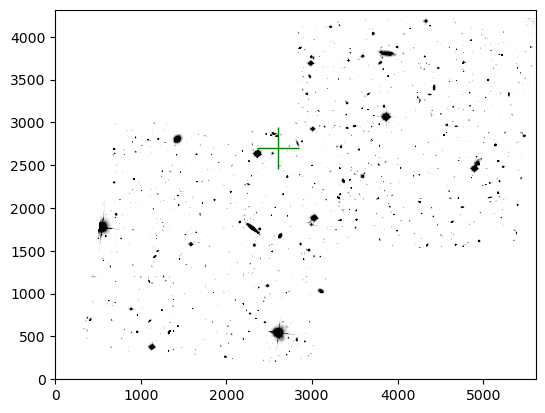

In [129]:
sky_mean, sky_median, sky_std = sigma_clipped_stats(img.data, sigma=3, maxiters=5)
norm = simple_norm([sky_std, 10*sky_std], 'linear', percent=100)
plt.imshow(img.data-sky_median,origin='lower',cmap='gray_r',norm=norm)
wcsinfo=img.data.wcs
sc = SkyCoord(ra=ra, dec=dec, unit='deg',frame="icrs", equinox='J2000')
s_coord=wcsinfo.world_to_pixel(sc)
plt.plot(s_coord[0],s_coord[1],"+",c="g",ms=30,lw=0.1)
#plt.imshow(img.cut_mask_image,origin='lower',cmap='Blues',alpha=img.cut_mask_image.astype(float)*0.5)
plt.show()

0.00045729295


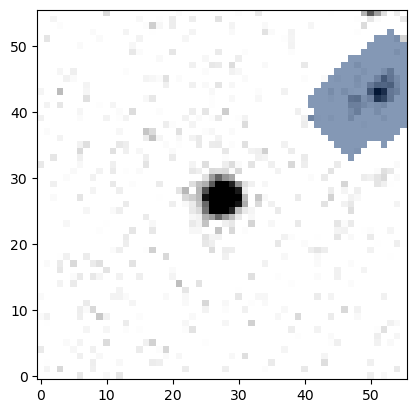

In [130]:
#imcut_new=imcut.at[img.cut_mask_image].set(0)
print(sky_median)
plt.imshow(img.cut_image-sky_median,origin='lower',cmap='gray_r',norm=norm)
#plt.imshow(img.cut_sigma_image,origin='lower',cmap='gray_r')
plt.imshow(img.cut_mask_image,origin='lower',cmap='Blues',alpha=img.cut_mask_image.astype(float)*0.5)

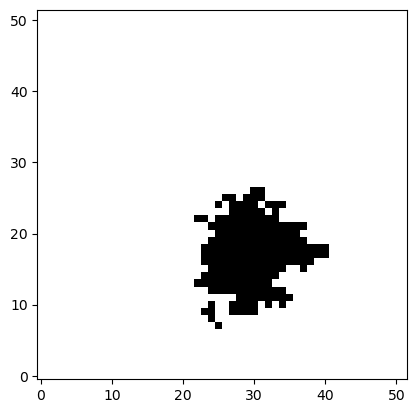

In [112]:
plt.imshow(img.cut_mask_image,origin='lower',cmap='gray_r')

# PSF

writing PSF to /disk/bifrost/yuanze/KBSS/Q1549/hst/Q1549_hst_f606w_acs_epsf.fits


total sources:  36
sources above thereshold flux : 12
sources above thereshold axis ratio : 9
sources within threshould fwhm : 8
sources isolate : 8
sources remove central bad : 8


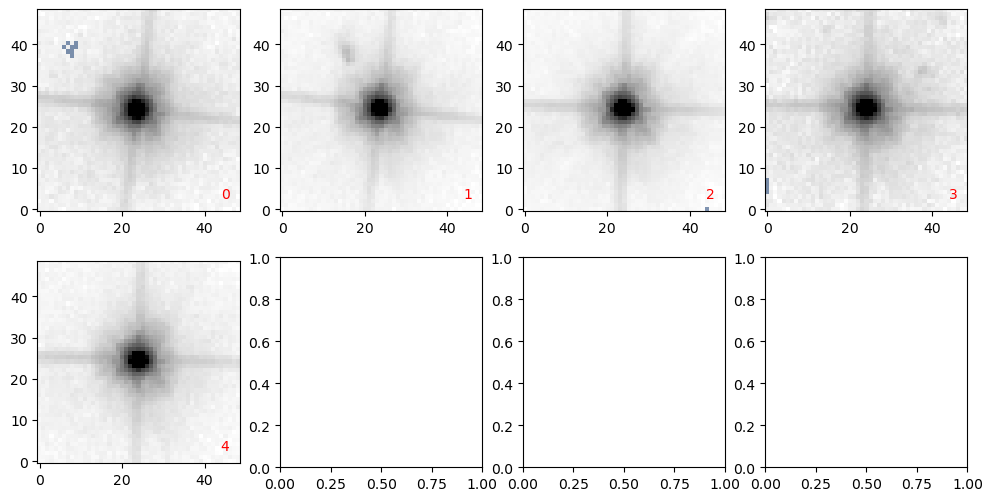

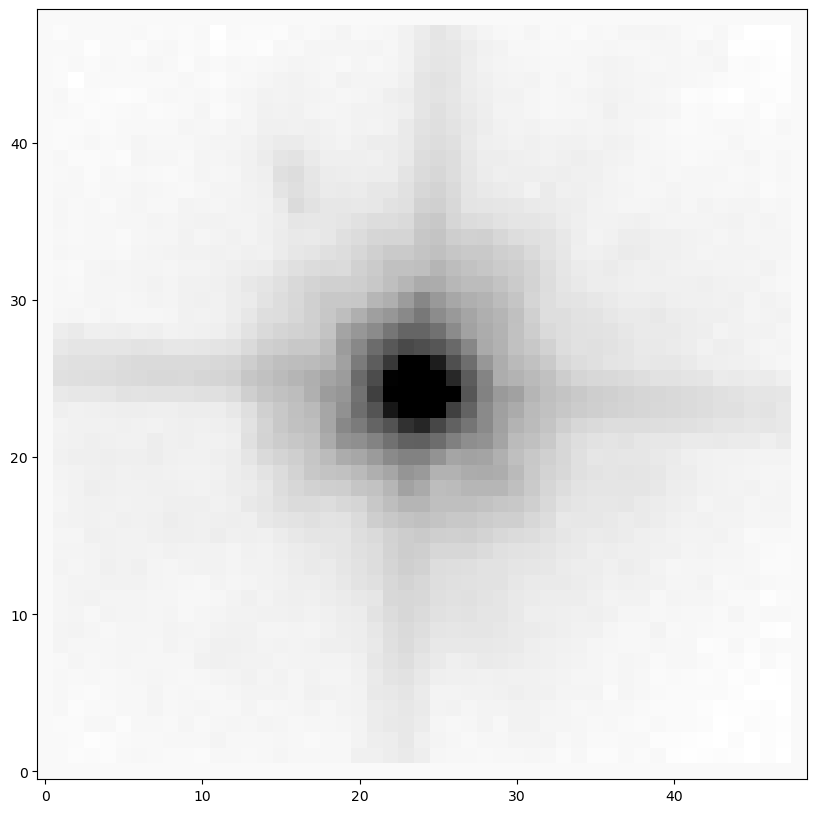

In [127]:
cutr = float (5)
fname = datapath
      
img = IM.image(fname)
hdu = fits.open(fname)
#outname = obspath+"/"+datatype+'/'+'q1549_'+datatype+'_'+subtype+'_epsf.fits'
outname = KBSSpath+"/"+field+"/"+datatype+'/'+field+'_'+datatype+'_{}_{}_epsf.fits'.format(filter,instrument)
print("writing PSF to",outname)
epsf = img.generate_PSFs(0.5, data = None, nsigma=2.0, fluxthreshould = 0.2, isolate = 0.07,qt = 0.5, sigfwhm = 2, a_TV=1e4,a_sky=0,
                    size = 49, oversampling=1, plot=True, filepaths=outname,droppsf=[0,3,5],crossmatch=True, notfit=False,makestackpsf=True)

# KCWI PSF
As an IFS, KCWI PSF generation needs special method including exposure map weighting.

In [23]:

from photutils.segmentation import SourceCatalog,deblend_sources,detect_threshold,detect_sources
from photutils.psf import extract_stars,EPSFBuilder

from spectral_cube import SpectralCube
from mathfunc import Maskellipse,polynomialfit,cross_match,elliptical_func
import jax.numpy as jnp
from images import fittingPSF

from astropy.convolution import Gaussian2DKernel
from astropy.table import Table, Column, join, join_skycoord
from astropy.stats import sigma_clipped_stats,gaussian_fwhm_to_sigma
from astroquery.xmatch import XMatch

In [405]:


def generate_ISF_PSF(data,emap,psfFWHM,wcs,nsigma=2.0, a_TV = 1e6, a_sky=1., fluxthreshould = 2, isolate = 0.1, qt = 0.8, sigfwhm = 2,
                    size = 31, oversampling=1, plot=True, filepaths=None, droppsf=[], notfit=False, crossmatch = False, makestackpsf = False):
    sky_mean, sky_median, sky_std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
    data -= sky_median
    mask = np.zeros_like(data, dtype=bool)
    mask[np.isnan(data)] = True
    mask[np.isinf(data)] = True
    psfFWHMpix = psfFWHM / np.abs(wcsinfo.pixel_scale_matrix[0,0] * 3600)
    thresholder = detect_threshold(data, nsigma=nsigma,mask=mask)
    sigma = psfFWHMpix * gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
    kernel.normalize()
    segm = detect_sources(data, thresholder, npixels=5,mask=mask)
    segm_data = segm.data
    props = SourceCatalog(data, segm)
    stars = Table(props.to_table(['xcentroid','ycentroid','semimajor_sigma','semiminor_sigma','orientation','segment_flux','fwhm','maxval_xindex','maxval_yindex']))
#    wcs = self.data.wcs
    ra, dec = wcs.all_pix2world(stars['xcentroid'], stars['ycentroid'], 0)
    Column_ra = Column(name='RA', data=ra)
    Column_dec = Column(name='DEC', data=dec)
    stars.add_columns([Column_ra, Column_dec])
    if crossmatch:
        t_o = XMatch.query(cat1=stars, cat2='vizier:I/355/gaiadr3', max_distance=1.5*psfFWHM*u.arcsec, 
                        colRA1='RA', colDec1='DEC')  # Gaia xmatch.
    else:
        t_o = stars
    if len(t_o) == 0:
        print ("original table have length {0}, become 0 after Gaia cross match".format(len(stars)))
        t_o = stars
    # filter source > fluxthreshould%
    print ('total sources: ',len(t_o))
    t_o = t_o[t_o['segment_flux'] > fluxthreshould*np.mean(t_o['segment_flux'])]
    print ('sources above thereshold flux :',len(t_o))
    q = t_o['semiminor_sigma']/t_o['semimajor_sigma']
    t_o = t_o[q>qt]
    print ('sources above thereshold axis ratio :',len(t_o))
#    mean, median, std = sigma_clipped_stats(np.array(t_o['fwhm']), sigma=3.0, maxiters=5)
 #   t_o = t_o[t_o['fwhm'] < median+sigfwhm*std]
 #   print(t_o['fwhm'])
 #   print ('sources within threshould fwhm :',len(t_o))
    cutPSF = []
    cutMask = []
    for i in range(len(t_o)):
        x = t_o['maxval_xindex'][i]
        y = t_o['maxval_yindex'][i]
        nlabel = segm_data[y,x]
        minx = np.max([0,x-size//2])
        maxx = np.min([data.shape[1],x+size//2+1])
        miny = np.max([0,y-size//2])
        maxy = np.min([data.shape[0],y+size//2+1])
        reachbound = False
        if minx == 0 or maxx == data.shape[1] or miny == 0 or maxy == data.shape[0]:
            reachbound = True
        localdata = data[miny:maxy,minx:maxx]
        localemap = emap[miny:maxy,minx:maxx]
        # scale the count rate by exposure time map
        weight=localemap/localemap.sum()
        localdata = localdata/weight
        localsege = segm_data[miny:maxy,minx:maxx]
        localmask = mask[miny:maxy,minx:maxx]
        localmask[(localsege!=nlabel)&(localsege!=0)] = True
        localmask[np.isnan(localdata)] = True
        localmask[np.isinf(localdata)] = True
        if np.sum(localmask/(size**2)) > isolate or reachbound:
            continue
        cutPSF.append(jnp.array(localdata,dtype=jnp.float32))
        cutMask.append(jnp.array(localmask,dtype=bool))
    print ('sources isolate :',len(cutPSF))

    circle = np.zeros([size,size],dtype=bool)
    circle1 = Maskellipse(circle,[0.5*size,0.5*size],0.25*size,0,0)
    removeloop = []
#   over-ride the central bad removal routine for this time
#    for loopx in range(len(cutPSF)):
#        lmask = np.array(cutMask[loopx])
#        if np.sum(lmask[circle1]) > 0:
#            removeloop.append(loopx)
    cutPSF = [i for j, i in enumerate(cutPSF) if j not in removeloop]
    cutMask = [i for j, i in enumerate(cutMask) if j not in removeloop]
    print ('sources remove central bad :',len(cutPSF))

    if len(droppsf) > 0:
        cutPSF = [i for j, i in enumerate(cutPSF) if j not in droppsf]
        cutMask = [i for j, i in enumerate(cutMask) if j not in droppsf]


    if plot:
        tlens = len(cutPSF)
        if (((tlens//5)+1)*5-tlens) < (((tlens//4)+1)*4-tlens):
            ncols = 5
            nrows = (tlens//5)+1 
        else:
            ncols = 4
            nrows = (tlens//4)+1
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows),squeeze=True)
        ax = ax.ravel()
        for i in range(tlens):
            image = cutPSF[i]
            norm = simple_norm(image, 'log', percent=99.)
            ax[i].imshow(image,cmap='Greys', origin='lower', norm=norm,interpolation='nearest')
            ax[i].imshow(np.array(cutMask[i],dtype=float), cmap='Blues', origin='lower', alpha=0.5*np.array(cutMask[i],dtype=float))
            ax[i].text(0.95, 0.05, str(i), color='r',transform=ax[i].transAxes,ha='right', va='bottom')
        plt.show()

    if notfit:
        return None

    epsf = fittingPSF(cutPSF,cutMask,oversampling = oversampling, a_TV = a_TV, a_sky=a_sky, makestackpsf = makestackpsf)

    if filepaths is not None:
        hdu = fits.PrimaryHDU(epsf)
        After = fits.HDUList([hdu])
        After.writeto(filepaths,overwrite= True)

    if plot:
        fig=plt.figure(figsize=(10,10))
        image = epsf
        norm = simple_norm(image, 'log', percent=99.)
        plt.imshow(image,cmap='Greys', origin='lower', norm=norm,interpolation='nearest')
        plt.show()

    return epsf

## Reading KCWI data

In [45]:
KCWIpath='/disk/bifrost/yuanze/KBSS/Q1549/BX101/kcwi_oned'
ecube='q1549-BX101_ecubes.fits'
icube='q1549-BX101_icubes.fits'

redshift=2.3806
inicube = SpectralCube.read(KCWIpath+'/'+icube) 
iniecube = SpectralCube.read(KCWIpath+'/'+ecube)
iniwcs=inicube.wcs.celestial




#Image generation
rest_wavelength=1550 * u.AA # Lya line
desired_wavelength = rest_wavelength * (redshift+1)
delta=20*u.AA
#kernel = Gaussian2DKernel(x_stddev=2,y_stddev=2)
plotcube = inicube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
temap = iniecube.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
emap = temap.mean(axis = 0, how = 'cube')
#plotcube = plotcube.spatial_smooth(kernel)
wcsinfo=iniwcs
squashed_data=plotcube.mean(axis = 0, how = 'cube')
#pixscale=np.abs(wcsinfo.pixel_scale_matrix[0,0] * 3600)

fname=KCWIpath+'/'+icube
img = IM.image(fname,IFS=True)


original table have length 28, become 0 after Gaia cross match
total sources:  28
sources above thereshold flux : 2
sources above thereshold axis ratio : 2
0.48469387755102034
sources isolate : 1
sources remove central bad : 1


/tmp/ipykernel_3305500/3430632793.py:57: RuntimeWarning: invalid value encountered in divide
  localdata = localdata/weight


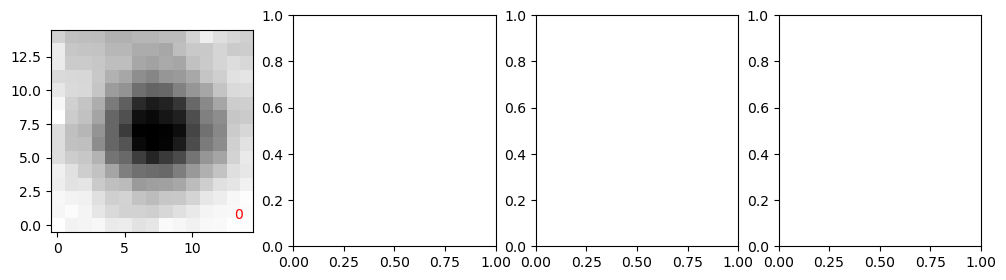

1.6962489 1.5043583 0.0


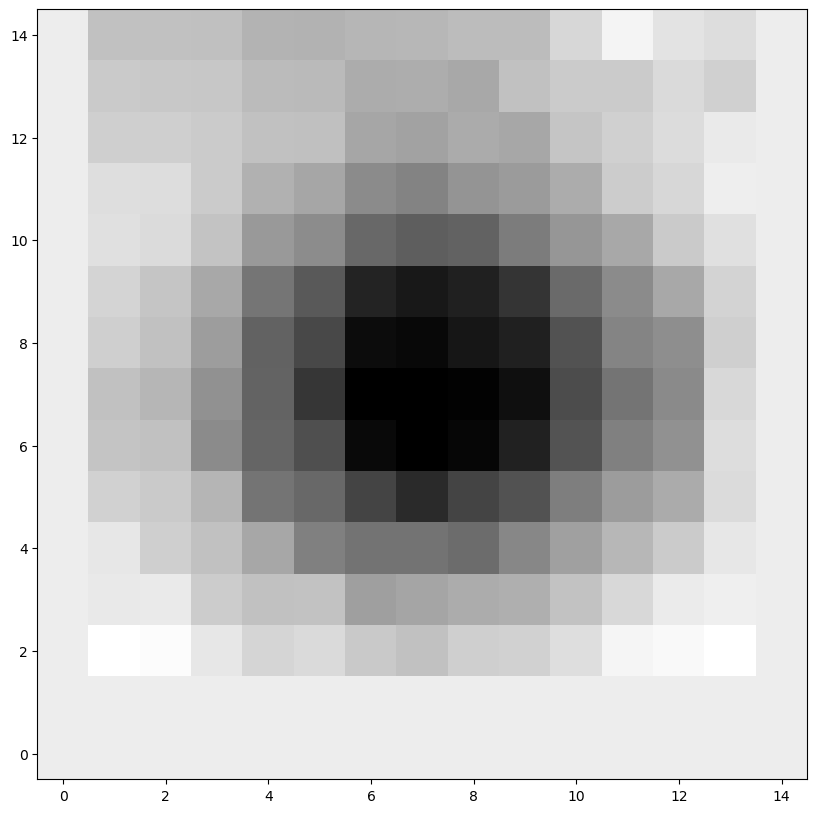

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.03966369e-04, -9.09562295e-05,
         3.12190423e-05,  2.21001959e-04,  1.62115888e-04,
         3.81814083e-04,  5.32257895e-04,  2.99377367e-04,
         2.60861270e-04,  1.12409900e-04, -5.37476481e-05,
        -7.84808872e-05, -1.52587352e-04,  0.00000000e+00],
       [ 0.00000000e+00,  2.22248054e-05,  1.19401502e-05,
         3.47105903e-04,  5.37331100e-04,  5.08595142

In [442]:

outname='/disk/bifrost/yuanze/KBSS/Q1549/BX101/kcwi_oned/KCWI_CIV_psf.fits'
generate_ISF_PSF(squashed_data.data,emap.value,0.5,wcsinfo,nsigma=2.0, fluxthreshould = 0.2, isolate = 0.1,qt = 0.1, sigfwhm =2, a_TV=1e4,a_sky=0,
                    size = 14, oversampling=1, plot=True, filepaths=outname,crossmatch=True, notfit=False,makestackpsf=False)

In [445]:
KCWI_filter=np.array([plotcube.spectral_axis,np.ones(len(plotcube.spectral_axis))*1/len(plotcube.spectral_axis)])
np.savetxt('/disk/bifrost/yuanze/software/GalfitS/src/data/filters/KCWI_squashed',KCWI_filter.T)

In [23]:
KCWIpath='/disk/bifrost/yuanze/KBSS/Q1549/BX101/kcwi_oned'
ecube='q1549-BX101_ecubes.fits'
icube_wcs ='q1549-BX101_icubes_wcs.fits'
fname=KCWIpath+'/'+icube_wcs
cube_wcs = SpectralCube.read(KCWIpath+'/'+icube_wcs)
aligned_wcs = cube_wcs.wcs.celestial
plotcube = cube_wcs.spectral_slab((desired_wavelength-delta), (desired_wavelength+delta))
squashed_data=plotcube.mean(axis = 0, how = 'cube')

redshift=2.3806
img = IM.image(fname,IFS=True)
header=img.data.header
img.data=squashed_data

In [40]:
ra, dec = 237.98053,19.15891
cutr = float (5)

imcut, cp = img.img_cut(ra,dec,cutr)
sky_mean, sky_median, sky_std = sigma_clipped_stats(imcut, sigma=3, maxiters=5)
sigimg = img.cal_sigma_image(1e5, gain = 1.)
img.cut_sigma_image = sigimg[cp[2]:cp[3],cp[0]:cp[1]]
#img.cut_mask_image = np.zeros_like(img.cut_sigma_image)
img.cut_mask_image = img.generate_cutmask(0.5,nsigma=2,magnification=4,source_dia = 3,growmethod=False,npixels=4,deblend=False,addgrow=5)
outname = KCWIpath+"/KCWI_squashed_image.fits"
print("writing cut image to",outname)
img.write_imcut(ra,dec,outname,header=header)



writing cut image to /disk/bifrost/yuanze/KBSS/Q1549/BX101/kcwi_oned/KCWI_squashed_image.fits


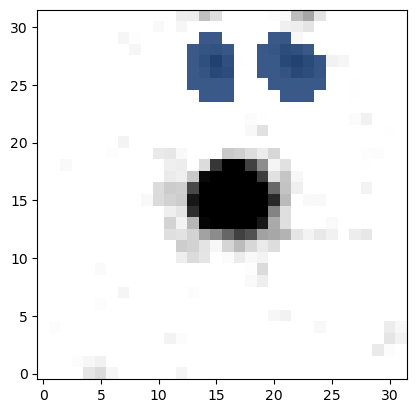

In [41]:
norm = simple_norm([sky_std, 10*sky_std], 'linear', percent=100)
plt.imshow(imcut-sky_mean,origin='lower',cmap='gray_r',norm=norm)
#plt.scatter(intsourceposi[0],intsourceposi[1]-1)
plt.imshow(img.cut_mask_image,origin='lower',cmap='Blues',alpha=img.cut_mask_image.astype(float)*0.8)
plt.show()

In [148]:
def generate_cutmask(img,psfFWHM, data = None, sdmask = None, nsigma=3.0, magnification=3., npixels = 5, nlevels=32, contrast=0.001, deblend=False, sky_level = None, source_dia = 0.5 ,max_grow_size=100, growmethod = True, nearbygrow = 0, addgrow=0, left_source = True):
        '''
        Parameters
        ----------
        psfFWHM : float
            FWHM of the imaging point spread function
        nsigma : float
            source detection threshold
        '''
        data = np.array(img.cut_image.copy())
        if sky_level is None:
            sky_mean, sky_median, sky_std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
            sky_level = 3*sky_std
        if sdmask is None:
            sdmask = np.zeros_like(data,dtype = bool)
        psfFWHMpix = psfFWHM / img.pixel_scales[0].value
        thresholder = detect_threshold(data, nsigma=nsigma)
        sigma = psfFWHMpix * gaussian_fwhm_to_sigma
        kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
        kernel.normalize()
        segm = detect_sources(data, thresholder, npixels=npixels, mask = sdmask)
        if deblend is True:
            segm = deblend_sources(data, segm, npixels=npixels, nlevels=nlevels, contrast=contrast,progress_bar = False, mask = sdmask)
        if left_source:
            if growmethod is True:
                sourcelabel = segm.data[int(img.sources_skycord_cut[1]),int(img.sources_skycord_cut[0])]
                segmnew, mask = grow_segmentation(segm, data, sourcelabel, source_dia = source_dia ,max_grow_size=max_grow_size, sky_level=sky_level, nearbygrow = nearbygrow, addgrow=addgrow)
            else:
                props = SourceCatalog(data, segm)
                intsourceposi = [int(img.sources_skycord_cut[0]),int(img.sources_skycord_cut[1])]
                mask=np.zeros_like(data, dtype=bool)
                mask[np.isnan(data)] = True
                mask[np.isinf(data)] = True
                sources = Table(props.to_table(['xcentroid','ycentroid','semimajor_sigma','semiminor_sigma','orientation','segment_flux','fwhm','maxval_xindex','maxval_yindex']))
                for loop in range(len(sources)):
                    position = (sources['xcentroid'][loop],sources['ycentroid'][loop])
                    a = sources['semimajor_sigma'][loop]
                    b = sources['semiminor_sigma'][loop]
                    theta = sources['orientation'][loop]*180./np.pi
                    masktmp=Maskellipse(mask,position,magnification*a,(1-b/a),theta)
                    # Y.D.: my proposal
                    xmesh, ymesh = jnp.meshgrid(jnp.arange(masktmp.shape[1]), jnp.arange(masktmp.shape[0]))
                    source_mask = elliptical_func(xmesh+0.5,intsourceposi,source_dia/2,0,0,ymesh+0.5)<0
                    if not any(masktmp[source_mask]):
                        #execute if masktmp is all False in the source region
                        # This criteria is to make sure the source is not masked out. Previous version was too loose such that for KCWI it doesn't work. Must be rewritten.
                        mask = masktmp
        else:
            if growmethod is True:
                segmnew, mask = grow_segmentation(segm, data, None, source_dia = source_dia ,max_grow_size=max_grow_size, sky_level=sky_level, nearbygrow = nearbygrow, addgrow=addgrow)
            else:
                props = SourceCatalog(data, segm)
                intsourceposi = [int(img.sources_skycord_cut[0]),int(img.sources_skycord_cut[1])]
                mask=np.zeros_like(data, dtype=bool)
                mask[np.isnan(data)] = True
                mask[np.isinf(data)] = True
                sources = Table(props.to_table(['xcentroid','ycentroid','semimajor_sigma','semiminor_sigma','orientation','segment_flux','fwhm','maxval_xindex','maxval_yindex']))
                for loop in range(len(sources)):
                    position = (sources['xcentroid'][loop],sources['ycentroid'][loop])
                    a = sources['semimajor_sigma'][loop]
                    b = sources['semiminor_sigma'][loop]
                    theta = sources['orientation'][loop]*180./np.pi
                    mask=Maskellipse(mask,position,magnification*a,(1-b/a),theta)       
        return mask    

In [155]:
mask=generate_cutmask(img,0.5,nsigma=4,magnification=4,source_dia = 6,growmethod=False,npixels=10,deblend=False,addgrow=5,left_source=True)

In [156]:
intsourceposi = [int(img.sources_skycord_cut[0]),int(img.sources_skycord_cut[1])]
print(mask[intsourceposi[1],intsourceposi[0]])
print(mask.astype(float)[int(img.sources_skycord_cut[1]),int(img.sources_skycord_cut[0])])

False
0.0


In [78]:
img.sources_skycord_cut[0]

46.38149556296914

In [57]:
hdul = fits.open(outname)

In [58]:
from astropy.wcs import WCS
header = hdul[0].header
wcs=


In [23]:
red_da=img.data[0:22,0:22]

In [35]:
from astropy.nddata import CCDData
typesearch=isinstance(img.data, CCDData)

In [56]:
CCDData.read(outname, hdu=0, unit='cR')

INFO: using the unit cR passed to the FITS reader instead of the unit 10^(-8)erg/s/cm3/arcsec2 in the FITS file. [astropy.nddata.ccddata]


CCDData([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], unit='cR')

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 237.98053  19.15891  
CRPIX : 46.38149556296914  50.36304428574113  
CD1_1 CD1_2  : -8.3333333333333e-05  0.0  
CD2_1 CD2_2  : 0.0  8.33333333333333e-05  
NAXIS : 96  99